# Understanding the Amazon Forest from Space

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://storage.googleapis.com/kaggle-competitions/kaggle/6322/logos/header.png")

## Importing Libraries

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Loading the Dataset

In [4]:
path = Path('/kaggle/input/planet-understanding-the-amazon-from-space/')
path.ls()

[PosixPath('/kaggle/input/planet-understanding-the-amazon-from-space/test-tif-v3'),
 PosixPath('/kaggle/input/planet-understanding-the-amazon-from-space/test-jpg-v2'),
 PosixPath('/kaggle/input/planet-understanding-the-amazon-from-space/train-tif-v2'),
 PosixPath('/kaggle/input/planet-understanding-the-amazon-from-space/train-jpg'),
 PosixPath('/kaggle/input/planet-understanding-the-amazon-from-space/test_v2_file_mapping.csv'),
 PosixPath('/kaggle/input/planet-understanding-the-amazon-from-space/sample_submission_v2.csv'),
 PosixPath('/kaggle/input/planet-understanding-the-amazon-from-space/train_v2.csv')]

## Multi-Classification

In [5]:
df = pd.read_csv(path/'train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


### Different Tags

In [6]:
df.pivot_table(index='tags', aggfunc=len).sort_values('image_name', ascending=False)

,image_name
tags,
clear primary,13636
partly_cloudy primary,3630
cloudy,2089
clear primary water,1850
agriculture clear primary road,1680
...,...
artisinal_mine clear conventional_mine primary road water,1
artisinal_mine clear cultivation primary road water,1
artisinal_mine clear habitation primary road,1


In [7]:
# GPU required
torch.cuda.is_available()

True

In [8]:
torch.backends.cudnn.enabled

True

### Defining Accuracy and F2-Score

In [10]:
def p_accuracy(pred, act, **kwargs):
    return accuracy_thresh(pred, act, thresh=0.2, **kwargs)
#This kaggle competition uses f2 score for the final eval. So we should use that as well.
def f2_score(pred, act, **kwargs):
    return fbeta(pred, act, beta=2, thresh=0.2, **kwargs)

### Transforms

In [11]:
def get_data(sz):
    tfms = get_transforms(do_flip=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)
    
    data = (
        ImageList
            .from_csv(path, 'train_v2.csv', folder="train-jpg", suffix=".jpg")
            .split_by_rand_pct(0.2)
            .label_from_df(label_delim=' ')
            .transform(tfms, size=sz)
            .add_test_folder('test-jpg-v2')
            .databunch(num_workers=0)
            .normalize(imagenet_stats)
    )
    return data

In [12]:
#Cause learning on 64x64
sz=64
data = get_data(sz)

### Classes

In [13]:
len(data.classes), data.classes

(17,
 ['agriculture',
  'artisinal_mine',
  'bare_ground',
  'blooming',
  'blow_down',
  'clear',
  'cloudy',
  'conventional_mine',
  'cultivation',
  'habitation',
  'haze',
  'partly_cloudy',
  'primary',
  'road',
  'selective_logging',
  'slash_burn',
  'water'])

### Displaying Images

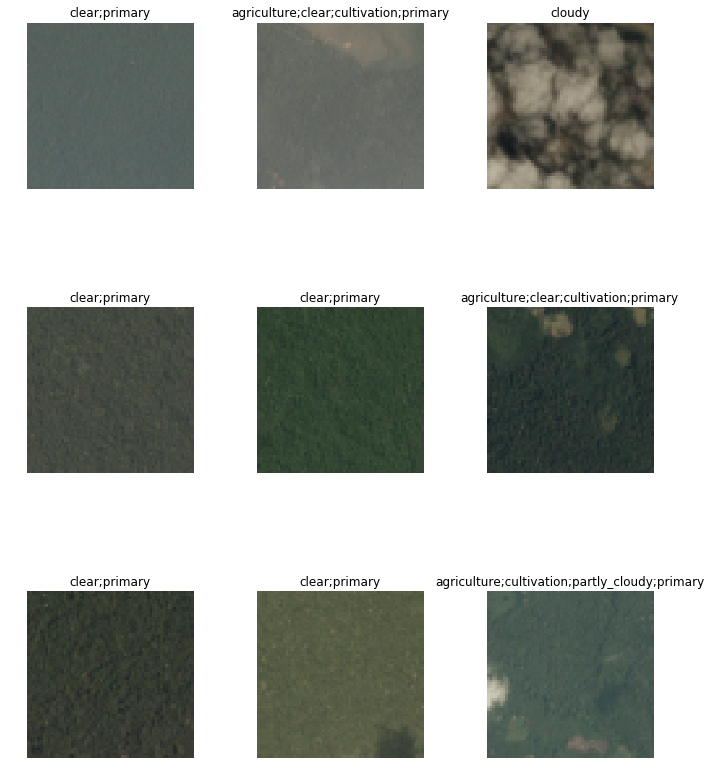

In [14]:
data.show_batch(rows=3, figsize=(10,12))

In [15]:
!mkdir -p /tmp/.cache/torch/checkpoints
!cp /kaggle/input/fastai-pretrained-models/resnet50-19c8e357.pth /tmp/.cache/torch/checkpoints/resnet50-19c8e357.pth

learn = cnn_learner(data, models.resnet50, metrics=[p_accuracy, f2_score], model_dir = Path('../kaggle/working'),path = Path("."))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


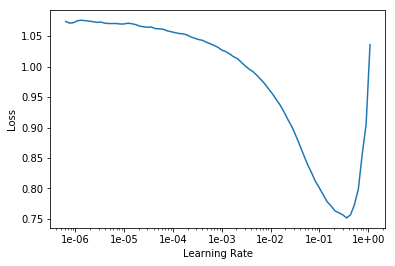

In [16]:
learn.lr_find()
learn.recorder.plot()

### Training the Model

In [17]:
lr = 0.01
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,p_accuracy,f2_score,time
0,0.154736,0.152360,0.934877,0.868584,03:54
1,0.119698,0.111967,0.939600,0.901915,03:04
2,0.109528,0.107610,0.950383,0.905309,03:03
3,0.103277,0.099703,0.949257,0.913279,03:03
4,0.098798,0.098998,0.950420,0.914059,03:03


In [18]:
learn.unfreeze() 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


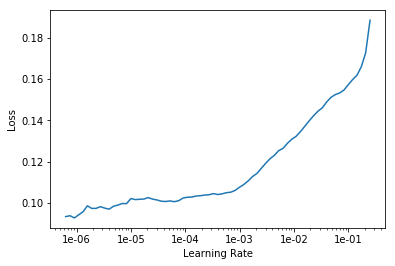

In [19]:
learn.lr_find()
learn.recorder.plot()

In [20]:
lr = 1e-4
learn.fit_one_cycle(4, slice(lr))

epoch,train_loss,valid_loss,p_accuracy,f2_score,time
0,0.098643,0.099027,0.950863,0.914459,03:14
1,0.094934,0.097838,0.952026,0.914478,03:14
2,0.096192,0.096812,0.951706,0.916193,03:13
3,0.092073,0.097557,0.952447,0.916383,03:15


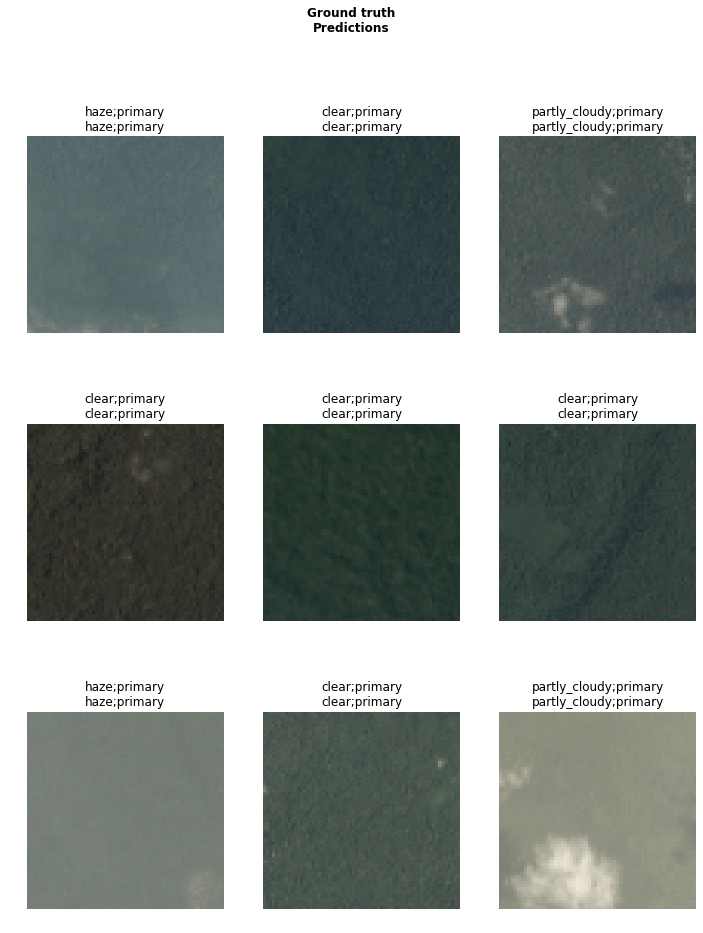

In [21]:
learn.show_results(rows=3, figsize=(12,15))

### Saving Model

In [22]:
learn.save('stage-2-rn50')

In [23]:
learn.export()

## Predicting on Test Set

In [24]:
test = ImageList.from_folder(path/'test-jpg-v2').add(ImageImageList.from_folder(path/'test-jpg-additional'))
len(test)

61191

In [25]:
learn = load_learner('../working/', test=test)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [26]:
thresh = 0.2
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]

In [27]:
submission = pd.read_csv(path/'sample_submission_v2.csv')
submission['tags'] = labelled_preds
submission.to_csv('submission.csv')